## Motivation

- Implement the algorithm SimpleTagBased, NormTagBased and TagBased-TFIDF with dataset [delicious](./delicious-2k/user_taggedbookmarks-timestamps.dat)
- Clean dataset [Titanic](./titanic/train.csv)

## Model of TagBased

- Score of **SimpleTagBased**
$$score(u,i)=\sum_t user\_tags[u,t] \times tag\_items[t,i]$$
where $user\_tags[u,t]$ is denoted times of user $u$ uses tag $t$, and $tag\_items[t, i]$ is denoted times of item $i$ tagged by tag $t$.
- Score of **NormTagBased**
$$score(u,i)=\sum_t\frac{user\_tags[u,t]}{user\_tags[u]} \times \frac{tag\_items[t,i]}{tag\_items[t]}$$
- Score of **TagBased-TFIDF**
$$score(u,i)=\sum_t \frac{user\_tags[u,t]}{log(1+tag\_users[t])} \times tag\_items[t,i]$$

## Model of Clean Titanic
- 
- 

In [9]:
import numpy as np
import pandas as pd
import random
import operator

## Delicious-Simple/Norm/TFIDF

In [10]:
class TagBased(object):
    def __init__(self, filename, tagbased='simple'):
        self.filename = filename
        self.load_data()
        self.random_split_data(0.2)
        self.init_state()
        self.test_recommend(tagbased)
    
    def load_data(self):
        print('loading data.....')
        filename = self.filename
        self.records = {}
        data = pd.read_csv(filename, delimiter='\t')
        for index, row in data.iterrows():
            # user for some book setting tag
            uid, bid, tid = row['userID'], row['bookmarkID'], row['tagID']
            # graph or tree
            self.records.setdefault(uid, {})
            self.records[uid].setdefault(bid, [])
            self.records[uid][bid].append(tid)
        print('Size of Data Set', data.shape[0])
        print('Number of person who sets tags', len(self.records))
        print('Finish Loading Data')
        
    def random_split_data(self, ratio, seed=2020):
        print('spliting data randomly.....')
        random.seed(seed)
        # build user-book according to tag
        self.train = {}
        self.test = {}
        for user in self.records.keys():
            for book in self.records[user].keys():
                if random.random() < ratio:
                    self.test.setdefault(user, {})
                    self.test[user].setdefault(book, [])
                    for tag in self.records[user][book]:
                        self.test[user][book].append(tag)
                else:
                    self.train.setdefault(user, {})
                    self.train[user].setdefault(book, [])
                    for tag in self.records[user][book]:
                        self.train[user][book].append(tag)
        print('Size of train ', len(self.train), '\nSize of test ', len(self.test))
        
    def init_state(self):
        print('initing the mainly variable.......')
        records = self.train
        self.user_tags = {}
        self.tag_books = {}
        self.user_books = {}
        for user, books in records.items():
            for book, tags in books.items():
                for tag in tags:
                    # The relationship between user and tag
                    self._add_value2mat(self.user_tags, user, tag, 1)
                    # the relationship between tag and item
                    self._add_value2mat(self.tag_books, tag, book, 1)
                    # the relationship between user and item
                    self._add_value2mat(self.user_books, user, book, 1)
        print('user_tags, tag_books, user_books initialize finish.')
        print('size of user_tags is {}, size of tag_books is {}, size of user_books is {}.'.format(len(self.user_tags), len(self.tag_books), len(self.user_books)))
    
    def _add_value2mat(self, dic, key, item, value=1):
        # build the number of key-value
        if key not in dic:
            dic.setdefault(key, {})
            dic[key].setdefault(item, value)
        else:
            if item not in dic[key]:
                dic[key][item] = value
            else:
                dic[key][item] += value
        
    
    def precision_and_recall(self, N, tagbased='simple'):
        print('calcing the precision and recall......')
        hit = 0
        h_recall = 0
        h_precision = 0
        for user, books in self.test.items():
            # if user not in trainset, we can't get some important things
            if user not in self.train:
                continue
            rank = self.recommend(user, N, tagbased)
            for book, rui in rank:
                if book in books:
                    hit += 1
            h_recall += len(books)
            h_precision += N
        return 1. * hit / h_precision, 1. * hit / h_recall
    # get Top N
    def recommend(self, user, N, tagbased='simple'):
        '''tagbased="simple"/"norm"/"tfidf"
        '''
#         print('recommending top-N for user.........')
        recommend_books = {}
        # scored for book, scores for sum (times of user using tag, multipy times of book using the same tag.)
        tagged_books= self.user_books[user]
        len_user_tags = len(self.user_tags[user])
        for tag, wut in self.user_tags[user].items():
            len_tag_books = len(self.tag_books[tag])
            for book, wti in self.tag_books[tag].items():
                if book in tagged_books:
                    continue
                if tagbased == 'norm':
                    wti = 1. * wti / len_tag_books
                    wut = 1. * wut / len_user_tags
                elif tagbased == 'tdidf':
                    wut = 1. * wut / np.log2(1 + len_user_tags)
                    
                if book not in recommend_books:
                    recommend_books[book] = wti * wut
                else:
                    recommend_books[book] += wti * wut  
        return sorted(recommend_books.items(), key=operator.itemgetter(1), reverse=True)[0:N]

    def test_recommend(self, tagbased='simple'):
        print('result for result evaluation:')
        print("%3s %10s %10s" % ('N',"precision",'recall'))
        for n in [5,10,20,40,60,80,100]:
            precision, recall = self.precision_and_recall(n, tagbased)
            print(precision, recall)
            print("%3d %10.3f%% %10.3f%%" % (n, precision * 100, recall * 100))

In [11]:
stb = TagBased('./delicious-2k/user_taggedbookmarks-timestamps.dat', 'simple')

loading data.....
Size of Data Set 437593
Number of person who sets tags 1867
Finish Loading Data
spliting data randomly.....
Size of train  1864 
Size of test  1775
initing the mainly variable.......
user_tags, tag_books, user_books initialize finish.
size of user_tags is 1864, size of tag_books is 36798, size of user_books is 1864.
result for result evaluation:
  N  precision     recall
calcing the precision and recall......
0.009932279909706547 0.00421072778601847
  5      0.993%      0.421%
calcing the precision and recall......
0.007392776523702032 0.006268242499641131
 10      0.739%      0.627%
calcing the precision and recall......
0.005135440180586907 0.008708550648356381
 20      0.514%      0.871%
calcing the precision and recall......
0.003781038374717833 0.012823580075601703
 40      0.378%      1.282%
calcing the precision and recall......
0.003094431903686983 0.015742380018182688
 60      0.309%      1.574%
calcing the precision and recall......
0.002765237020316027 0.01

In [12]:
stb = TagBased('./delicious-2k/user_taggedbookmarks-timestamps.dat', 'norm')

loading data.....
Size of Data Set 437593
Number of person who sets tags 1867
Finish Loading Data
spliting data randomly.....
Size of train  1864 
Size of test  1775
initing the mainly variable.......
user_tags, tag_books, user_books initialize finish.
size of user_tags is 1864, size of tag_books is 36798, size of user_books is 1864.
result for result evaluation:
  N  precision     recall
calcing the precision and recall......
0.004063205417607223 0.0017225704579166467
  5      0.406%      0.172%
calcing the precision and recall......
0.003216704288939052 0.0027274032250346907
 10      0.322%      0.273%
calcing the precision and recall......
0.0024830699774266367 0.00421072778601847
 20      0.248%      0.421%
calcing the precision and recall......
0.0020033860045146727 0.0067945834728934396
 40      0.200%      0.679%
calcing the precision and recall......
0.0016835966892400302 0.00856500311019666
 60      0.168%      0.857%
calcing the precision and recall......
0.001530756207674943

In [13]:
stb = TagBased('./delicious-2k/user_taggedbookmarks-timestamps.dat', 'tfidf')

loading data.....
Size of Data Set 437593
Number of person who sets tags 1867
Finish Loading Data
spliting data randomly.....
Size of train  1864 
Size of test  1775
initing the mainly variable.......
user_tags, tag_books, user_books initialize finish.
size of user_tags is 1864, size of tag_books is 36798, size of user_books is 1864.
result for result evaluation:
  N  precision     recall
calcing the precision and recall......
0.009932279909706547 0.00421072778601847
  5      0.993%      0.421%
calcing the precision and recall......
0.007392776523702032 0.006268242499641131
 10      0.739%      0.627%
calcing the precision and recall......
0.005135440180586907 0.008708550648356381
 20      0.514%      0.871%
calcing the precision and recall......
0.003781038374717833 0.012823580075601703
 40      0.378%      1.282%
calcing the precision and recall......
0.003094431903686983 0.015742380018182688
 60      0.309%      1.574%
calcing the precision and recall......
0.002765237020316027 0.01

|       |Simple        |TagBased    |Norm          |TagBased  |TFIDF|TagBased|
| :----:|     :----:   |   :----:   |    :----:    |:----:    |   :----:    |:----:    |
| N     | Precision    | Recall     |Precision     | Recall   |Precision    | Recall   |
| 5     | 0.993%        | 0.421%     |0.406% |0.172% |0.993%       | 0.421% |
| 10    | 0.739%        |  0.627%     |0.322%|0.273%   |0.739%       | 0.627% |
|20|0.514% |0.871%|0.248%|0.421%|0.514% |0.871%|
|40|0.378%|1.282%|0.200%|0.679%|0.378%|1.282%|
|60|0.309%|1.574%|0.168% | 0.857%|0.309%|1.574%|
|80|0.277%|1.876%|0.153%|1.038%|0.277% |1.876%|
|100|0.249%|2.115%|0.133%  | 1.124%|0.249%|2.115%|

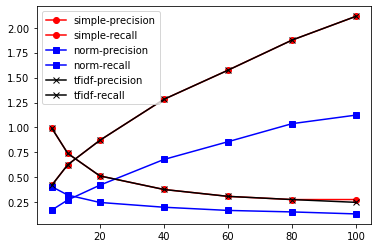

In [29]:
# why not return a variable, SB
simple_tb_pre = [0.993, 0.739, 0.514, 0.378, 0.309, 0.277, 0.277]
simple_tb_re = [0.421, 0.627, 0.871, 1.282,1.574,1.876, 2.115]
norm_tb_pre = [0.406, 0.322, 0.248, 0.200, 0.168, 0.153, 0.133]
norm_tb_re = [0.172,0.273,0.421,0.679,0.857,1.038,1.124]
tfidf_tb_pre = [0.993,0.739,0.514,0.378,0.309, 0.277, 0.249]
tfidf_tb_re = [0.421,0.627, 0.871, 1.282, 1.574, 1.876, 2.115]
x = [5, 10, 20, 40, 60, 80, 100]
import matplotlib.pyplot as plt
plt.plot(x, simple_tb_pre, 'ro-', label='simple-precision')
plt.plot(x, simple_tb_re, 'ro-',label='simple-recall')
plt.plot(x, norm_tb_pre, 'bs-', label='norm-precision')
plt.plot(x, norm_tb_re, 'bs-',label='norm-recall')
plt.plot(x, tfidf_tb_pre, 'kx-', label='tfidf-precision')
plt.plot(x, tfidf_tb_re, 'kx-',label='tfidf-recall')
plt.legend()

## Clean Titanic

### Import Libraries

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
train = pd.read_csv('../L2/titanic/train.csv')
test = pd.read_csv('../L2/titanic/test.csv')

In [3]:
import pandas_profiling

### Trainset

In [ ]:
train.profile_report()

In [ ]:
train.info()

In [ ]:
train.shape

In [ ]:
train.decribe()

### Testset

In [4]:
test.profile_report()

In [ ]:
test.info()

In [ ]:
test.shape

In [ ]:
test.decribe()

In [ ]:
test.sample()

[1.A Statistical Analysis & ML workflow of Titanic](https://www.kaggle.com/masumrumi/a-statistical-analysis-ml-workflow-of-titanic)